# Unet

[Unet](https://arxiv.org/abs/1505.04597) is a Deep Learning model for image segmenation created in 2015. It was originally used for biomedical image segmentation, and in this notebook we'll apply it to a similar task.  The goal of the model will be to learn to segment the cells membrane from the rest of the cell, as  shown bellow. 

In [1]:
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
import os

In [2]:
img = imread("data/input/img.tif")
label = imread("data/output/img.tif")

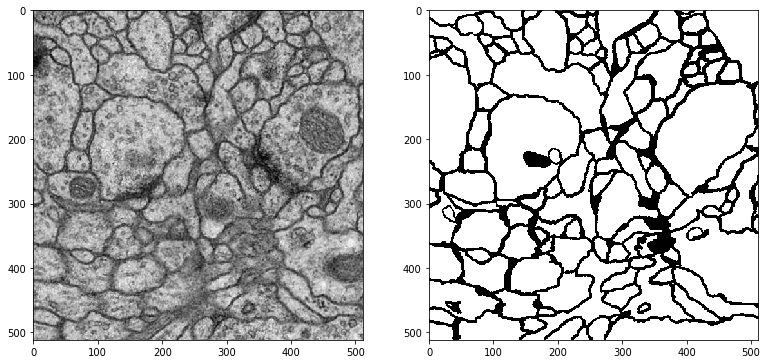

In [3]:
fig,ax = plt.subplots(1,2,figsize=(13,8))
ax[0].imshow(img,cmap="gray")
ax[1].imshow(label,cmap="gray");

Other similar image segmentation model includes [FCN](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf) , from rougthly the same time (2014).

# Data Augmentation

We need good few images to train the model however the training dataset is pityfully small, just a single image. Thankfully we can get around this using image augmentation. This is the process of warping the image by applying transformations such as image rotations, shifts and rescaling in order to create new images which look similar.


In [4]:
import numpy as np
import Augmentor

In [5]:
img_dir = "data/input"
label_dir = "data/output"
#needs to be fully path, change to you correct path where you wanna create images
train_dir = "/home/dom/code/deep-learning/papers/unet/data/augmented/train" 
test_dir = "/home/dom/code/deep-learning/papers/unet/data/augmented/test" 

Since we need to apply the same augmentations to both original and segmented image, they both must have the same name.


In [71]:
%%bash 
tree data

data
├── input
│   └── img.tif
└── output
    └── img.tif

2 directories, 2 files


In [6]:
#make train and test directories
os.makedirs(train_dir,exist_ok=True)
os.makedirs(test_dir,exist_ok=True)

We will output the newly generated images to the augmented directory.

In [76]:
def build_pipeline(img_dir,ground_truth_dir,augmented_dir): 
    
    p = Augmentor.Pipeline(source_directory=img_dir,output_directory=augmented_dir)
    p.ground_truth(ground_truth_dir)
    p.set_seed(1)
    p.rotate(probability=1, max_left_rotation=5, max_right_rotation=5)
    p.flip_left_right(probability=0.5)
    p.zoom_random(probability=0.5, percentage_area=0.8)
    p.flip_top_bottom(probability=0.5)
    return p

In [77]:
p1 = build_pipeline(img_dir,label_dir,train_dir)
p2 = build_pipeline(img_dir,label_dir,test_dir)

Initialised with 1 image(s) found.
Output directory set to /home/dom/code/deep-learning/papers/unet/data/augmented/train.1 ground truth image(s) found.
Initialised with 1 image(s) found.
Output directory set to /home/dom/code/deep-learning/papers/unet/data/augmented/test.1 ground truth image(s) found.


In [78]:
#generate testing images
p1.sample(1000) 
p2.sample(50) 

Processing <PIL.Image.Image image mode=L size=512x512 at 0x7F5AF003EF28>: 100%|██████████| 1000/1000 [00:09<00:00, 108.59 Samples/s]
Processing <PIL.Image.Image image mode=L size=512x512 at 0x7F5AB021C9B0>: 100%|██████████| 50/50 [00:00<00:00, 113.67 Samples/s]


The generated images can now be found in the augmented directory. The segmented image is prefixed by '_groundtruth' and the original image prefixed with 'input_original', examples of the file names are shown bellow.

```
'_groundtruth_(1)_input_img.tif_f7e44e74-3784-4aab-acb4-fff8c18f4308.tif'   input_original_img.tif_f7e44e74-3784-4aab-acb4-fff8c18f4308.tif
```


Lets create a pytorch dataset to easily load the images.

In [7]:
import os
from torch.utils.data import Dataset
import torch
import cv2
from  glob import glob

In [8]:
class ImageDataset(Dataset):
    def __init__(self, img_dir):
        super(ImageDataset,self).__init__()
        self.labels_path = glob(os.path.join(img_dir  ,"_groundtruth*"))
        self.imgs_path = glob(os.path.join(img_dir,"input*"))
        self.imgs_path.sort()
        self.labels_path.sort()
    
    def __len__(self):
        return len(self.imgs_path)
        
    def __getitem__(self,i):
        #read as greyscale and add channels first C x W x H
        x = np.expand_dims(cv2.imread(self.imgs_path[i],0),0) / 255
        x = torch.from_numpy(x.astype("float32"))
        y = np.expand_dims(cv2.imread(self.labels_path[i],0),0) > 125
        y = torch.from_numpy(y.astype("int64"))
        y = y.squeeze()
        return x,y 

In [9]:
dataset = ImageDataset(train_dir)

Plot a few of the images to make sure the augmentation worked well.

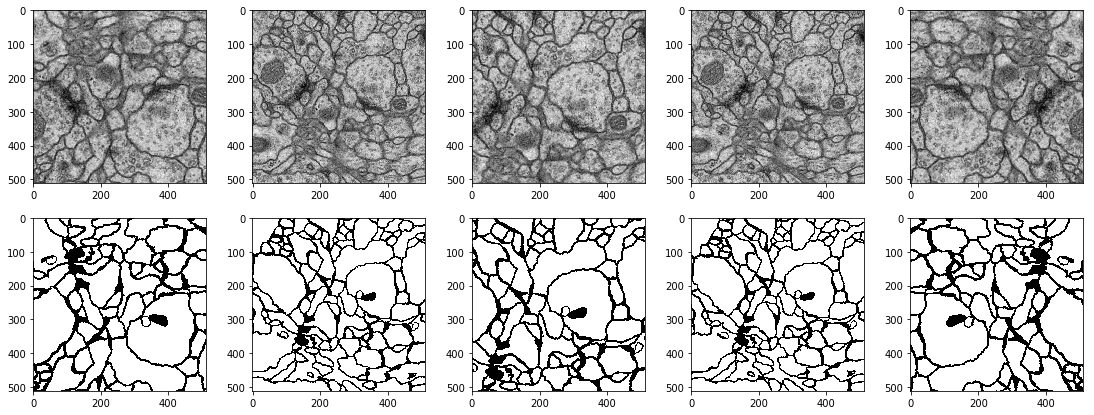

In [10]:
fig,axes = plt.subplots(2,5,figsize=(19,7))

for i in range(5):
    x,y = dataset[i]
    axes[0][i].imshow(torch.squeeze(x),cmap="gray")
    axes[1][i].imshow(torch.squeeze(y),cmap="gray")

# Model

The model architecture is shown bellow, given the shape, it should be clear why it's called Unet.  Its quite intresting since it contains no dense (fully connected) layers and skip connections similar to a resnet. Also   due to the lack of dense layers, the output of the model is a tensor. Another nice part about the lack of dense layers is that the model can take variable sized images.

![img](img/unet-arch.png)



The code can be found in `unet.py`, hopefully along with the diagram, the architecture should make sense.

My implementation isn't completely true to the diagram since it adds padding to the convolutions. This was mostly to simplify the model, since it means the output of each convolutional layer (the feature map) doesn't shrink in shape. This prevents me needing to crop the downward convolutional layers output when it is concatennated with the upward convolutional layers. 

In [11]:
from unet import Unet

In [12]:
#https://github.com/pytorch/pytorch/issues/6098
# DEIVCE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# DEVICE = "cpu"
DEVICE = "cuda:0"

In [13]:
unet = Unet(out_channels=2)
unet = unet.to(DEVICE)

In theory we should be able to change out_channels, to another number if we wanted to classify more classes, although I'm yet to try.

# Training
    
The model will output a tensor of shape $ height \times width \times n\_classes $. Each entry in the  $ 1 \times 1 \times n\_classes $ slice of  the tensor will represent the probablity that that pixel belongs to a particular class. We can then compare this tensor to the correctly labeled matrix of shape $ height \times width $ and calculate the loss using cross entropy.


** TODO: Need to add some drawing, sounds confusing without also reword  **.

In [14]:
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F

In [15]:
train_dataset = ImageDataset(train_dir)
train_loader = DataLoader(train_dataset, batch_size=1,
                        shuffle=True, num_workers=4)


In [16]:
opt = optim.Adam(unet.parameters())

In [17]:
def train(model, opt, dataloader):
    model.train()
    total_loss = 0
    for batch_idx, (x,y) in enumerate(tqdm(train_loader)):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        opt.zero_grad()
        y_pred = model(x)
        loss = F.cross_entropy(y_pred,y)
        total_loss += float(loss.data)
        loss.backward()
        opt.step()
        
    return total_loss

In [18]:
epochs = 1
for _ in range(epochs):
    train(unet,opt,train_loader)
    

100%|██████████| 1000/1000 [07:38<00:00,  2.18it/s]


# Testing

After some training we can test it.

In [20]:
test_dataset = ImageDataset(test_dir)
test_loader = DataLoader(test_dataset, batch_size=1,
                        shuffle=True, num_workers=4)

In [21]:
# test it on first image
x,y = next(iter(test_loader))
y_pred = unet(x.to(DEVICE))

In [22]:
img_pred = torch.argmax(y_pred,dim=1).squeeze()

Text(0.5,1,'OG Image')

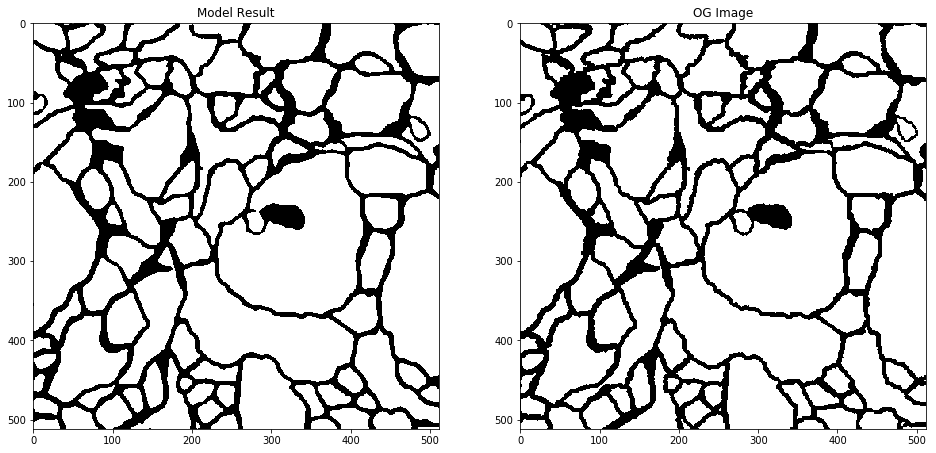

In [23]:
fig, axes = plt.subplots(1,2,figsize=(16,8))
axes[0].imshow(img_pred,cmap="gray")
axes[0].set_title("Model Result")
axes[1].imshow(y.squeeze(),cmap="gray")
axes[1].set_title("OG Image")

In [24]:
#need to test more throughly
np.mean(y.squeeze().data.numpy() == img_pred.squeeze().cpu().data.numpy())

0.9716377258300781